Copyright © 2025 Technical University of Denmark

In [1]:
import numpy as np
from lcg_plus.conversions import r_to_dB, dB_to_r, Delta_to_dB, to_dB
from lcg_plus.base import State
from lcg_plus.operations.symplectic import squeezing, beam_splitter, expand_symplectic_matrix

from thewalrus.symplectic import xxpp_to_xpxp, xpxp_to_xxpp
from thewalrus.decompositions import blochmessiah

from lcg_plus.plotting import plot_wigner_marginals, plot_wig
from lcg_plus.effective_sqz import effective_sqz
from lcg_plus.gkp_squeezing import Q_expval

import matplotlib as mpl
from matplotlib import pyplot as plt

hbar = 2
colwidth = 3.41667

fs = 10

mpl.rcParams.update({'font.size': fs, 
                     "text.usetex":  True, 
                     'font.family':'serif',
                     'xtick.labelsize': 8, 
                     'ytick.labelsize':8 })


kwargs = {'grid': 'rect', 
          'fontsize' : fs, 
          'title': None, 
          'figsize' :(colwidth,colwidth), 
          'linewidth':1,
          'xlim': 5,
          'plim': 5}

fig_kwargs = {'dpi':800, 'bbox_inches': 'tight'}



## Generalised photon subtraction parameters from Takase et al. https://doi.org/10.1038/s41534-023-00772-y

hbar =2
r1 = dB_to_r(-9.5)


r2 = dB_to_r(6.9)
r3 = dB_to_r(5.2)

D1 = np.exp(-r1)
D2 = np.exp(-r2)
D3 = np.exp(-r3)
g = 0.59

## Coherent bifurcation conditions
print('1st condition, (D2^(-2)+g^2 D1^(-2)) * D3^(-2) = 1', D3**(-2)*(D2**(-2)+g**2*D1**(-2)))
print('2nd condition, D1^2 << D2^2', f'{D1**2} << {D2**2}')

print('factor', D2**2/D1**2)


1st condition, (D2^(-2)+g^2 D1^(-2)) * D3^(-2) = 1 0.9985827654331072
2nd condition, D1^2 << D2^2 0.11220184543019635 << 4.897788193684462
factor 43.65158322401659


In [2]:
#For a given g, find bloch-messiah decomp of circuit implementing QND operation

g = 0.59
QND = np.array([[1,0,g,0],[0,1,0,0],[0,0,1,0],[0,-g,0,1]])
r = np.arcsinh(g/2)
theta = np.arcsin(-1/np.cosh(r))/2

S1 = expand_symplectic_matrix(squeezing(r, 0),[0], 2)
S2 = expand_symplectic_matrix(squeezing(r, np.pi),[1], 2)

B1 = beam_splitter(theta, np.pi)
B2 = beam_splitter(theta+np.pi/2, np.pi)

Stot = B2 @ S1 @ S2 @ B1

print(np.allclose(QND,Stot))

True


In [3]:
def coh_bifur_params(n, g = 1, c = 1, w = np.sqrt(np.pi), factor = None, out = False):
    """Generate coherent bifurcation circuit parameters
    Args:
        n (int): photon number
        g (float): QND interaction strength
        w (float): grid spacing
        factor (float): D2^2 = factor*D1^2
        out (bool): 
    Returns:
        r1 (float): squeezing of input state
        g (float): QND interaction strength
        r2 (float): squeeizng of ancillary states
        r3 (float): inline squeezing prior to pnrd
    """
    #Task: find r1 from w = sqrt(pi) = D1 sqrt(2 n)
    D1 = w/np.sqrt(2*n)
    r1 = -np.log(D1)

    #Task: find r2, r3 such that D1^2 << D2^2 and D3^(-2)*(D2^(-2)+g^2 * D1^(-2)) == c
    
    
    if factor:
        #Choose D2^2 = factor  D1^2
        D2 = np.sqrt(D1**2 * factor)
    else:
        D2 = np.exp(1) #For comparison with Table 1 in Takase et al. https://doi.org/10.1038/s41534-023-00772-y
    r2 = -np.log(D2)
    
    D3 = np.sqrt((D2**(-2)+g**2 * D1**(-2))/c)
    r3 = -np.log(D3)
    if out:
        print(f'r1 {r_to_dB(r1)} [dB]')
        print(f'r2 {r_to_dB(r2)} [dB]')
        print(f'r3 {r_to_dB(r3)} [dB]')
    return r1, g, r2, r3


In [4]:
def coherent_bifurcation_step(state, n, params, eta = 1, infid = 1e-6):
    """Perform a coherent bifurcation step. Updates the state object.
    Args:
        state (bosonicplus.base.State): input state
        n (int): photon number measurement
        params (np.ndarray): list of parameters
        eta (float): transmissivity of loss channel
        infid (float): infidelity of fock approximation for the measurement
    Returns: 
        prob (float): probability of photon measurement     
    """
    
    r1, g, r2, r3 = params
    
    sq_state = State(1) #Generate ancillary state
    sq_state.apply_symplectic(squeezing(r2,0))
    state.add_state(sq_state) #Tensor product the two states
   
    QND = np.array([[1,0,g,0],[0,1,0,0],[0,0,1,0],[0,-g,0,1]])
    
    state.apply_symplectic(QND) #Apply QND
    state.apply_symplectic_fast(squeezing(r3,0),[1]) #Apply squeezing on last mode

    state.apply_loss(np.repeat(eta, 2), np.zeros(2)) #Apply a pure loss channel on both modes
    
    state.post_select_fock_coherent(1, n, inf=infid, out = True)
    prob = state.norm 
    state.normalise() #Divide by norm
    return prob
    

In [5]:
from lcg_plus.effective_sqz import effective_sqz
from lcg_plus.gkp_squeezing import Q_expval
from lcg_plus.conversions import Delta_to_dB, to_dB

def print_state_info(state, grid = 'r'):
    Dx = effective_sqz(state,grid+'x')
    Dp = effective_sqz(state,grid+'p')
    Ds = np.sqrt(0.5*(Dx**2+Dp**2))
    
    print('Dx', Delta_to_dB(Dx).real, '[dB]')
    print('Dp', Delta_to_dB(Dp).real, '[dB]')
    print('Ds', Delta_to_dB(Ds).real, '[dB]')
    print('Q0', Q_expval(state,'0'))
    print('Q1', Q_expval(state,'1'))
    print('Qs0', Q_expval(state,'s0'))
    print('Qs1', Q_expval(state,'s1'))

## Synthesizing a logical GKP state

Bifurcation step 0
r1 -7.06970109961791 [dB]
r2 8.685889638065037 [dB]
r3 7.183599563812178 [dB]
Dx 7.069701099617908 [dB]
Dp -7.069701099617911 [dB]
Ds -4.223688383467288 [dB]
Q0 (1.1429100763431244+0j)
Q1 (2.8570896985865266+0j)
Qs0 (1.2650615930434643+0j)
Qs1 (2.734267481700731+0j)
--------------------------------------------------
Bifurcation step 1.
Measuring 8 photons in mode 1.
Data shape before measurement, [(1, 4), (1, 4, 4)].
Probability of measurement = 2.915e-02
Data shape after measurement, [(45, 2), (1, 2, 2)]
Dx 7.246539264358772 [dB]
Dp 6.544549667651031 [dB]
Ds 6.881376261014214 [dB]
Q0 (2.3638832674940056-6.523102370759037e-16j)
Q1 (0.639102388301163+4.956972332603726e-16j)
Qs0 (2.1028531058777555-1.9103100178108345e-15j)
Qs1 (1.7054862392144376-1.553499082845855e-15j)
Probability 0.029152831142847235


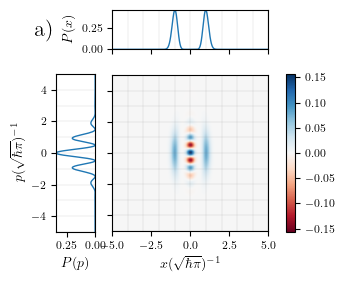

--------------------------------------------------
Bifurcation step 2.
Measuring 8 photons in mode 1.
Data shape before measurement, [(45, 4), (1, 4, 4)].
Probability of measurement = 4.381e-02
Data shape after measurement, [(3321, 2), (1, 2, 2)]
num weights after reduction 153
Dx 7.483467610833898 [dB]
Dp 8.854311998689287 [dB]
Ds 8.115024730485565 [dB]
Q0 (0.46674052071727135-1.6984738810711664e-12j)
Q1 (2.2046252148361978-1.6984743147520354e-12j)
Qs0 (1.5910983603251998+2.3852106270996765e-12j)
Qs1 (2.1822083585343854+7.086397441069536e-13j)
Probability 0.0012771528427261245


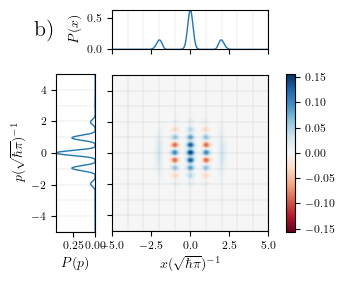

--------------------------------------------------
Bifurcation step 3.
Measuring 8 photons in mode 1.
Data shape before measurement, [(153, 4), (1, 4, 4)].
Probability of measurement = 4.878e-02
Data shape after measurement, [(11781, 2), (1, 2, 2)]
num weights after reduction 325
Dx 7.702148796937449 [dB]
Dp 10.317909051583197 [dB]
Ds 8.816001180971586 [dB]
Q0 (2.12807255204244-9.770232740251641e-11j)
Q1 (0.3783663924704542-4.51559050026161e-11j)
Qs0 (2.027280536202558-6.336052730117163e-11j)
Qs1 (1.7512521870568167-7.697090981619893e-11j)
Probability 6.229778590990152e-05


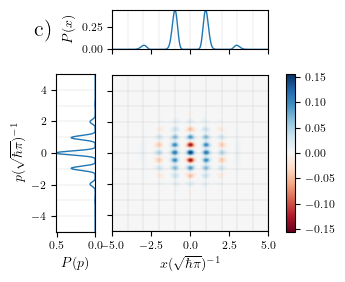

--------------------------------------------------
Bifurcation step 4.
Measuring 8 photons in mode 1.
Data shape before measurement, [(325, 4), (1, 4, 4)].
Probability of measurement = 5.134e-02
Data shape after measurement, [(25425, 2), (1, 2, 2)]
num weights after reduction 561
Dx 7.929335639617969 [dB]
Dp 11.381118432784572 [dB]
Ds 9.320955099557203 [dB]
Q0 (0.32405302463032015-3.0192281725953396e-11j)
Q1 (2.0846215271043715-3.0192281725953396e-11j)
Qs0 (1.7800615980221146-1.0517350223148911e-10j)
Qs1 (2.0207845038467456+6.471753702060913e-11j)
Probability 3.1985772284939877e-06


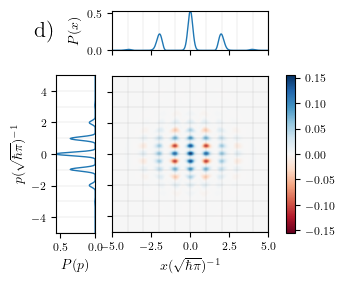

total prob 3.1985772284939877e-06


In [6]:
#Setting up the simulation for preparing a logical GKP state

g = 1 #QND interaction strength
c = 1
w = np.sqrt(np.pi)
nt = 8 #Target photon number
N = 4 #Number of bifurcation steps
eta = 1 #Loss channel transmissivity

print(f'Bifurcation step 0')
#Generate the bifurcation parameters
params = coh_bifur_params(nt, g, c, w, out = True) 
r1 = params[0]

#Generate input squeezed state
state = State(1)
state.apply_symplectic(squeezing(r1,0))
print_state_info(state)

x = np.linspace(-15,15,300) #For plotting the Wigner function
labels = ['a)', 'b)', 'c)', 'd)']

pattern = np.repeat(nt,N) 
probs = np.zeros(N)
for i, n in enumerate(pattern):
    print('-'*50)
    print(f'Bifurcation step {i+1}.')
    probs[i] = coherent_bifurcation_step(state, n, params, eta = eta) #Perform the bifurcation
    if i != 0:
        if eta == 1:
            state.reduce_pure(np.sum(pattern[0:i+1]), infid = 1e-8) #Reduce the number of Gaussians
        else:
            state.reduce_mixed(sd = 14) #Reduce the number of Gaussians
        print('num weights after reduction', state.num_weights)
        
    print_state_info(state)
    print('Probability', np.prod(probs[0:i+1]))

    W = state.get_wigner_log(x,x)
    fig, ax, axx, axp, axv = plot_wigner_marginals(W.real, x,x, **kwargs)
    axx.text(-0.5, 1.25, labels[i], fontsize = 16, transform=ax.transAxes)

    #plt.savefig(f'figures/W_coherent_bifur_step_{i}.pdf', **fig_kwargs)
    plt.show()

print('total prob', np.prod(probs))

num weights 287
Dx 7.0949428880842795 [dB]
Dp 6.617732446591802 [dB]
Q0 (0.6378061556582573+3.299863899487631e-16j)
Q1 (2.3535142174620045+5.3128095754974976e-17j)
(0.8419782549776932-114681.24990264636j)


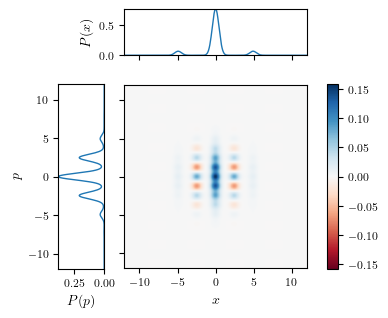

In [7]:
from lcg_plus.states.from_sf import prepare_gkp_bosonic
from lcg_plus.fidelity import overlap_log

## Compare with Gaussian GKP
D1 = np.exp(-r1)

gkp = prepare_gkp_bosonic([0,0], D1**2)
print('num weights', gkp.num_weights)
print('Dx', Delta_to_dB(effective_sqz(gkp,'rx').real), '[dB]')
print('Dp', Delta_to_dB(effective_sqz(gkp,'rp').real), '[dB]')
print('Q0', Q_expval(gkp,'0'))
print('Q1', Q_expval(gkp,'1'))

print(overlap_log(gkp, state))
x = np.linspace(-12,12,300)
W = gkp.get_wigner_log(x,x)
plot_wigner_marginals(W.real, x,x)
plt.show()


## Synthesizing a qunaught state

Bifurcation step 0
r1 -11.049101186338286 [dB]
r2 8.685889638065037 [dB]
r3 11.095019643030419 [dB]
Dx 11.049101186338284 [dB]
Dp -11.049101186338286 [dB]
Ds -8.065508409529397 [dB]
Q0 (1.0598210293260588+0j)
Q1 (2.9401789706739407+0j)
Qs0 (1.1160635010413351+0j)
Qs1 (2.883936494836358+0j)
--------------------------------------------------
Bifurcation step 1.
Measuring 10 photons in mode 1.
Data shape before measurement, [(1, 4), (1, 4, 4)].
Probability of measurement = 2.060e-02
Data shape after measurement, [(66, 2), (1, 2, 2)]
Dx 11.14087395185287 [dB]
Dp 3.531896400748662 [dB]
Ds 5.847656969122228 [dB]
Q0 (2.5573042592974207+5.166087826621868e-16j)
Q1 (1.394320625356238-5.163377321190654e-16j)
Qs0 (2.3879004990112818-2.5996457590771183e-16j)
Qs1 (0.6154612772190242+1.339802834648962e-16j)
Probability 0.02059868939744421


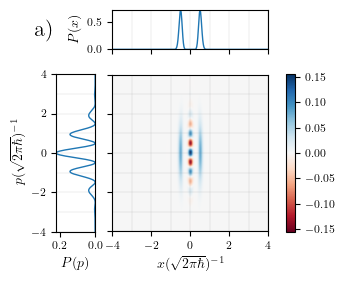

--------------------------------------------------
Bifurcation step 2.
Measuring 10 photons in mode 1.
Data shape before measurement, [(66, 4), (1, 4, 4)].
Probability of measurement = 3.092e-02
Data shape after measurement, [(7381, 2), (1, 2, 2)]
num weights after reduction 231
Dx 11.276358455989097 [dB]
Dp 5.843858007243271 [dB]
Ds 7.760894161075001 [dB]
Q0 (1.4159686855687506+4.800772128600974e-12j)
Q1 (2.525168436509351-4.856039063292879e-12j)
Qs0 (0.44617899788675125+7.944033885570745e-13j)
Qs1 (2.225206011442178+7.944034969772917e-13j)
Probability 0.0006368992756316681


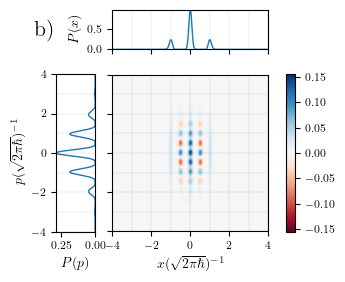

--------------------------------------------------
Bifurcation step 3.
Measuring 10 photons in mode 1.
Data shape before measurement, [(231, 4), (1, 4, 4)].
Probability of measurement = 3.438e-02
Data shape after measurement, [(26796, 2), (1, 2, 2)]
num weights after reduction 496
Dx 11.402309518121932 [dB]
Dp 7.3155629713670445 [dB]
Ds 8.894983199575247 [dB]
Q0 (2.4083185205887614+3.567352468790809e-11j)
Q1 (1.5315779010873354-2.166708891975346e-11j)
Qs0 (2.145315604396625+3.840380384577749e-11j)
Qs1 (0.3603251704566905-3.410759050409898e-11j)
Probability 2.1897090764530183e-05


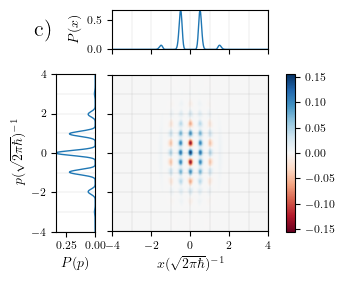

--------------------------------------------------
Bifurcation step 4.
Measuring 10 photons in mode 1.
Data shape before measurement, [(496, 4), (1, 4, 4)].
Probability of measurement = 3.613e-02
Data shape after measurement, [(58311, 2), (1, 2, 2)]
num weights after reduction 861
Dx 11.525555462899513 [dB]
Dp 8.397241383741102 [dB]
Ds 9.685611552974008 [dB]
Q0 (1.6120637957542248-1.9171350982523708e-10j)
Q1 (2.3301037275468524+2.046379190419719e-10j)
Qs0 (0.3078937908006527-3.8862457414461093e-10j)
Qs1 (2.09857289418687+3.959635510100701e-10j)
Probability 7.911321469412496e-07


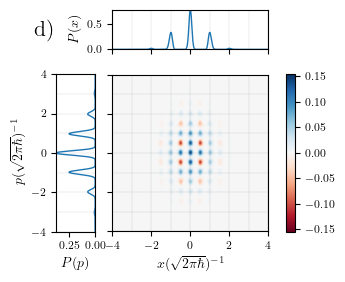

--------------------------------------------------
Bifurcation step 5.
Measuring 10 photons in mode 1.
Data shape before measurement, [(861, 4), (1, 4, 4)].
Probability of measurement = 3.720e-02
Data shape after measurement, [(101926, 2), (1, 2, 2)]
num weights after reduction 1326
Dx 11.644994563794842 [dB]
Dp 9.248974713188717 [dB]
Ds 10.283801964655868 [dB]
Q0 (2.2631833731980318-8.857767006414833e-09j)
Q1 (1.682845687672404-1.4610686271119414e-08j)
Qs0 (2.068363547497653-1.4163740603761674e-08j)
Qs1 (0.2723069253061935-1.1402099057023635e-08j)
Probability 2.942656579809101e-08


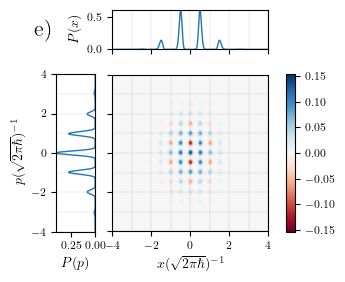

--------------------------------------------------
Bifurcation step 6.
Measuring 10 photons in mode 1.
Data shape before measurement, [(1326, 4), (1, 4, 4)].
Probability of measurement = 3.792e-02
Data shape after measurement, [(157641, 2), (1, 2, 2)]
num weights after reduction 1891
Dx 11.758657962477436 [dB]
Dp 9.94618535592127 [dB]
Ds 10.758548426033638 [dB]
Q0 (1.740588281302628+7.96033934628535e-08j)
Q1 (2.2100413999722646-7.250649070415986e-08j)
Qs0 (0.2465040755811651+3.222006591998422e-08j)
Qs1 (2.0475569679903356-3.166996317841356e-08j)
Probability 1.115925742684247e-09


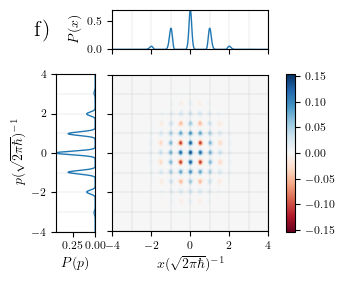

total prob 1.115925742684247e-09


In [8]:
#Setting up the simulation for preparing a qunaught state

kwargs = {'grid': 'square', 
          'fontsize' : fs, 
          'title': None, 
          'figsize' :(colwidth,colwidth), 
          'linewidth':1,
          'xlim': 4,
          'plim': 4}


g = 1 #QND interaction strength
c = 1
w = np.sqrt(np.pi/2)
nt = 10 #Target photon number
N = 6 #Number of bifurcation steps
eta = 1 #Loss channel transmissivity

print(f'Bifurcation step 0')
#Generate the bifurcation parameters
params = coh_bifur_params(nt, g, c, w, out = True) 
r1 = params[0]

#Generate input squeezed state
state = State(1)
state.apply_symplectic(squeezing(r1,0))
print_state_info(state)

x = np.linspace(-15,15,300) #For plotting the Wigner function
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

pattern = np.repeat(nt,N) 
probs = np.zeros(N)
for i, n in enumerate(pattern):
    print('-'*50)
    print(f'Bifurcation step {i+1}.')
    probs[i] = coherent_bifurcation_step(state, n, params, eta = eta) #Perform the bifurcation
    if i != 0:
        if eta == 1:
            state.reduce_pure(np.sum(pattern[0:i+1]), infid = 1e-8) #Reduce the number of Gaussians
        else:
            state.reduce_mixed(sd = 14) #Reduce the number of Gaussians
        print('num weights after reduction', state.num_weights)
        
    print_state_info(state, 's')
    print('Probability', np.prod(probs[0:i+1]))

    W = state.get_wigner_log(x,x)
    fig, ax, axx, axp, axv = plot_wigner_marginals(W.real, x,x, **kwargs)
    axx.text(-0.5, 1.25, labels[i], fontsize = 16, transform=ax.transAxes)

    #plt.savefig(f'figures/W_coherent_bifur_step_{i}.pdf', **fig_kwargs)
    plt.show()

print('total prob', np.prod(probs))